In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer

df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
target = 'converted'
dfTypes = df.dtypes

categoricalTypes = dfTypes[dfTypes==object]
numericalTypes = dfTypes[(dfTypes=='float64')|(dfTypes=='int64')]
numericalTypes = numericalTypes[numericalTypes.index != target]

for column in categoricalTypes.index:
    df[column] = df[column].fillna('NA')

for column in numericalTypes.index:
    df[column] = df[column].fillna(0.0)

X = df.drop(columns=[target])
y = df[target]
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.25, random_state=1)




#q1
col_roc_auc = {};
for col in numericalTypes.index:
    col_roc_auc[col] = roc_auc_score(y_train.values, df_train[col].values)

col_roc_auc

#answer: number_of_courses_viewed

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

In [5]:
from sklearn.linear_model import LogisticRegression

#q2:
def train(df_train, y_train):
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return model, dv


def calc_auc_and_predict(df_val, y_val, dv, model):
    X_val = dv.transform(df_val.to_dict(orient='records'))
    y_pred = model.predict_proba(X_val)[:, 1]

    return roc_auc_score(y_val, y_pred), y_pred

model, dv = train(df_train, y_train)
roc_auc, y_pred = calc_auc_and_predict(df_val, y_val, dv, model)

print(round(roc_auc, 3))
#answer: 0.8171316268814112 (closest 0.72)

0.817


0.00 0.500
0.01 0.500
0.02 0.500
0.03 0.500
0.04 0.500
0.05 0.500
0.06 0.500
0.07 0.500
0.08 0.500
0.09 0.500
0.10 0.500
0.11 0.500
0.12 0.500
0.13 0.500
0.14 0.500
0.15 0.500
0.16 0.500
0.17 0.500
0.18 0.500
0.19 0.500
0.20 0.500
0.21 0.500
0.22 0.500
0.23 0.500
0.24 0.500
0.25 0.500
0.26 0.500
0.27 0.504
0.28 0.508
0.29 0.512
0.30 0.512
0.31 0.512
0.32 0.516
0.33 0.516
0.34 0.520
0.35 0.520
0.36 0.529
0.37 0.529
0.38 0.537
0.39 0.553
0.40 0.570
0.41 0.571
0.42 0.591
0.43 0.595
0.44 0.612
0.45 0.617
0.46 0.625
0.47 0.631
0.48 0.645
0.49 0.642
0.50 0.648
0.51 0.657
0.52 0.672
0.53 0.688
0.54 0.697
0.55 0.711
0.56 0.713
0.57 0.723
0.58 0.721
0.59 0.727
0.60 0.721
0.61 0.728
0.62 0.734
0.63 0.730
0.64 0.736
0.65 0.728
0.66 0.719
0.67 0.730
0.68 0.724
0.69 0.714
0.70 0.707
0.71 0.710
0.72 0.698
0.73 0.685
0.74 0.692
0.75 0.687
0.76 0.691
0.77 0.683
0.78 0.678
0.79 0.671
0.80 0.663
0.81 0.660
0.82 0.656
0.83 0.639
0.84 0.636
0.85 0.626
0.86 0.612
0.87 0.591
0.88 0.582
0.89 0.575
0.90 0.566

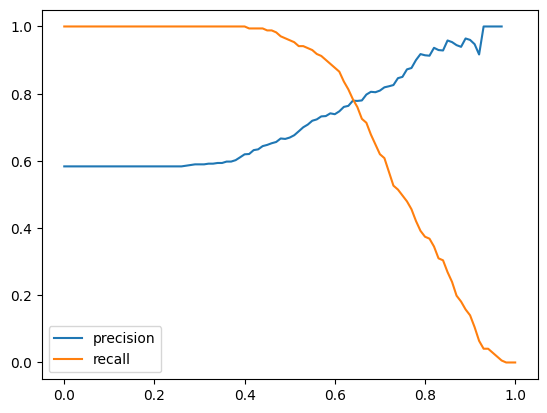

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
#q3:

scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    score = roc_auc_score(y_val, y_pred >= t) 
    print('%.2f %.3f' % (t, score))

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])
intersection_idx = df_scores['diff'].idxmin()
intersection_threshold = df_scores.loc[intersection_idx, 'threshold']

print(f"Just checking its close zero: {df_scores['diff'].iloc[intersection_idx]:.3f}")
print(f"Precision and Recall intersect at threshold: {intersection_threshold:.3f}")

#answer: 0.64 (closest 0.0.745)

Maximum F1 score: 0.812
Threshold at max F1: 0.570


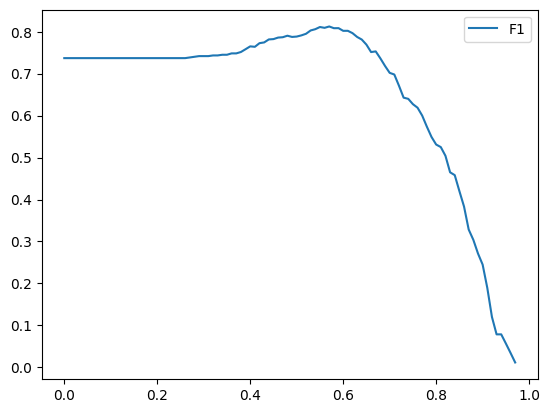

In [12]:
#q4:

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)


df_scores['F1'] = 2 * ((df_scores['precision']*df_scores['recall'])/(df_scores['precision'] + df_scores['recall']))
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')

plt.legend()

# Find the row with maximum F1 score
max_f1_row = df_scores.loc[df_scores['F1'].idxmax()]

print(f"Maximum F1 score: {max_f1_row['F1']:.3f}")
print(f"Threshold at max F1: {max_f1_row['threshold']:.3f}")

#answer: 0.570 (closest 0.54)

In [17]:
from sklearn.model_selection import KFold

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train=df_train[target]
y_val=df_val[target]
y_test=df_test[target]

# Remove target from dataframes
del df_train[target]
del df_val[target]
del df_test[target]

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    y_train = df_train[target].values
    y_val = df_val[target].values

    del df_train[target]
    del df_val[target]

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=1.0 %.3f +- %.3f' % (np.mean(scores), np.std(scores)))
#answer: 0.036 (closest 0.06)

C=1.0 0.822 +- 0.036


In [18]:
#q6

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train=df_train[target]
y_val=df_val[target]
y_test=df_test[target]

# Remove target from dataframes
del df_train[target]
del df_val[target]
del df_test[target]


def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


for C in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        y_train = df_train[target].values
        y_val = df_val[target].values

        del df_train[target]
        del df_val[target]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%.7f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

#answer: C=0.0000010

C=0.0000010 0.560 +- 0.024
C=0.0010000 0.867 +- 0.029
C=1.0000000 0.822 +- 0.036
